In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-13pqjhnf
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-13pqjhnf
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=8d270b28d14b887917fc61ad9c3d44f04c52519aaf8c907cfb01c2f2435a5130
  Stored in directory: /tmp/pip-ephem-wheel-cache-m861beqk/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [5]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [6]:
#loading the dataset from tensorflow library
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.EBB4N2_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.EBB4N2_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [11]:
def normalize(input_image, target_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask=1
  return input_image, target_image

In [12]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask=tf.image.resize(datapoint['segmentation_mask'], (128, 128),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image,input_mask=normalize(input_image,input_mask)
  return input_image, input_mask

In [13]:
train_length=info.splits['train'].num_examples
batch_size=64
buffer_size=1000
steps_per_epoch=train_length//batch_size

In [21]:
train_images=dataset['train'].map(load_image,num_parallel_calls=tf.data.AUTOTUNE)
test_images=dataset['test'].map(load_image,num_parallel_calls=tf.data.AUTOTUNE)


In [22]:
class Augment(tf.keras.layers.Layer):
  def __init__(self,seed=42):
    super().__init__()
    #both use the same seed, so they'll make the same random changes
    self.augment_inputs=tf.keras.layers.RandomFlip(mode="horizontal",seed=seed)
    #self.augment_labels=tf.keras.layers.RandomFlip(mode="horizontal",seed=seed)
  def call(self,inputs,labels):
    inputs=self.augment_inputs(inputs)
    #labels=self.augment_labels(labels)
    return inputs,labels

In [24]:
#building the inputs pipeline
train_batches=(train_images.cache().shuffle(buffer_size).batch(batch_size).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE))
test_batches=test_images.batch(batch_size)

In [26]:
#Visualizing image
def display(display_list):
  plt.figure(figsize=(15,15))
  title=['Input Image','True Mask','Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

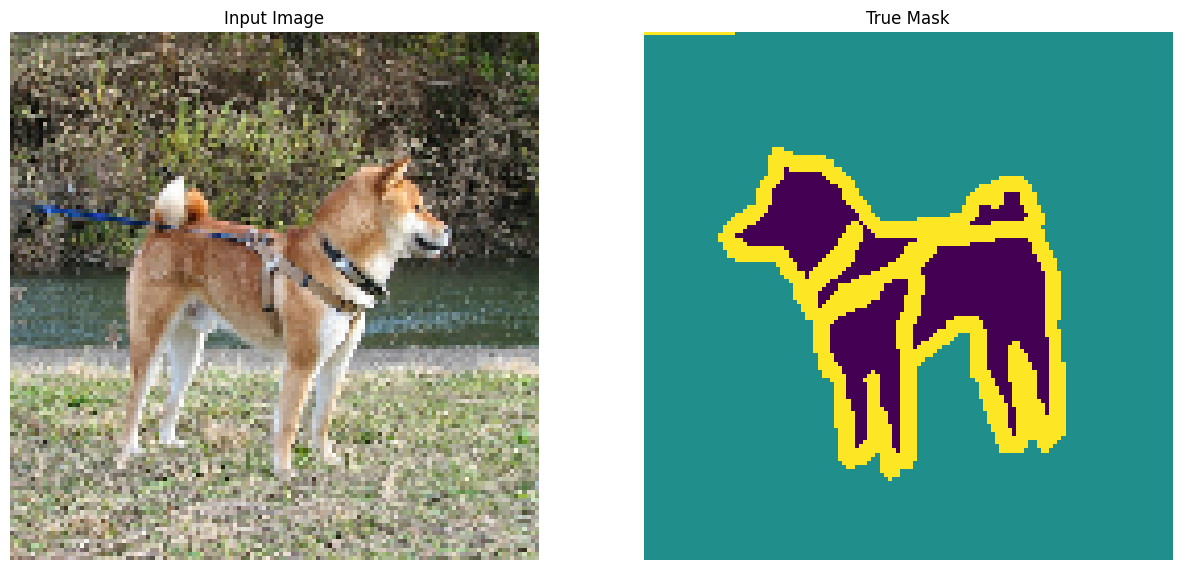

In [28]:
for images,masks in train_batches.take(2):
  sample_image,sample_mask=images[0],masks[0]
display([sample_image,sample_mask])